In [51]:
# Load libraries
import requests
import base64
import os
import pandas as pd
import csv

In [52]:
# Authenticate Spotify Web API
def authenticate_client(client_id, client_secret):
    """
    Authenticate the client with Spotify API and retrieve the access token.

    Parameters:
    - client_id (str): The client ID for Spotify API authentication.
    - client_secret (str): The client secret for Spotify API authentication.

    Returns:
    - access_token (str): The access token for accessing Spotify API.
    """
    auth_header_value = base64.b64encode(f"{client_id}:{client_secret}".encode()).decode()

    # Define the authentication options
    auth_options = {
        'url': 'https://accounts.spotify.com/api/token',
        'headers': {
            'Authorization': f'Basic {auth_header_value}'
        },
        'data': {
            'grant_type': 'client_credentials'
        }
    }
    
    # Make a POST request to retrieve the access token
    response = requests.post(**auth_options)
    
    if response.status_code == 200:
        access_token = response.json()['access_token']
        return access_token
    else:
        print("Authentication error:", response.text)
        return None

In [67]:
# Get access token
client_id='58cea115aaf94e0d9ab169aa367f5207' # DEMO CLIENT ID
client_secret='60930726e8b34d4487344401ae1e23b1' # DEMO CLIENT SECRET
access_token = authenticate_client(client_id, client_secret)
print(access_token)

BQAkO-q6DLRK-5r0Yr5ApD0RDDCeUDCLIv_bAPacUX5L45guDlK0PR115qK6qr2VTC6AkL7See4-rHAp-JjEKr2w_2gzu3v4eTQbdu0odi1Bi5Ci-Cg


In [54]:
# Load top & bottom 10 streamed songs from CSV file
# Get the current working directory
current_dir = os.getcwd()

# Specify the filename
filename = 'top_bottom_taylor_songs.csv'

# Construct the full path to the CSV file into a DataFrame
csv_path = os.path.join(current_dir, filename)

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_path)
print(df)

                                                Album  \
0                                               Lover   
1                                                1989   
2                                                 NaN   
3                                           Midnights   
4                                                1989   
5                                               Lover   
6                                            Folklore   
7                                                1989   
8                                          Reputation   
9                                          Reputation   
10                                           Fearless   
11                                           Fearless   
12                                           Fearless   
13                                           Fearless   
14  Sounds of the Season: The Taylor Swift Holiday...   
15  Sounds of the Season: The Taylor Swift Holiday...   
16  Sounds of the Season: The T

In [65]:
# Check the structure of the DataFrame
print(df.info())

# Check for missing values
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Track Name               14 non-null     object
 1   Album Name               14 non-null     object
 2   Release Time             14 non-null     int64 
 3   Artist Name              14 non-null     object
 4   Available Markets Count  14 non-null     int64 
 5   Duration                 14 non-null     int64 
 6   Explicit                 14 non-null     bool  
 7   Popularity               14 non-null     int64 
 8   Track ID                 14 non-null     object
 9   Is Local                 14 non-null     bool  
 10  Streams                  14 non-null     int64 
 11  Category                 14 non-null     object
dtypes: bool(2), int64(5), object(5)
memory usage: 1.2+ KB
None
Track Name                 0
Album Name                 0
Release Time               0
Arti

In [66]:
# Check for duplicates
print("Number of duplicate rows:", df.duplicated().sum())

# Remove duplicates
df = df.drop_duplicates()

Number of duplicate rows: 0


In [55]:
# Function to get track details from Spotify API
def get_track_details(album, song):
    url = "https://api.spotify.com/v1/search"
    params = {
        "q": f"track:{song} album:{album} artist:Taylor Swift",
        "type": "track",
        "limit": 1
    }
    headers = {
        "Authorization": 'Bearer ' + access_token
    }

    response = requests.get(url, params=params, headers=headers)

    if response.status_code == 200:
        data = response.json()
        if data["tracks"]["items"]:
            track_data = data["tracks"]["items"][0]
            return track_data
        else:
            print(f"No track found for '{song}' in album '{album}'")
    else:
        print(f"Error: {response.status_code}")

# Function to extract required details from track data
def extract_track_details(track_data):
    track_name = track_data["name"]
    album_name = track_data["album"]["name"]
    release_time = track_data["album"]["release_date"].split('-')[0]
    artist_name = track_data["artists"][0]["name"]
    available_markets_count = len(track_data["available_markets"])
    duration = track_data["duration_ms"]
    explicit = track_data["explicit"]
    popularity = track_data["popularity"]
    track_id = track_data["id"]
    is_local = track_data["is_local"]

    return {
        "Track Name": track_name,
        "Album Name": album_name,
        "Release Time": release_time,
        "Artist Name": artist_name,
        "Available Markets Count": available_markets_count,
        "Duration": duration,
        "Explicit": explicit,
        "Popularity": popularity,
        "Track ID": track_id,
        "Is Local": is_local
    }

In [57]:
# Empty list to store song data
song_data = []

# CSV file to save the extracted data
csv_file_path = 'extracted_songs_data.csv'

# Open the CSV file in 'append' mode and write the header if the file is empty
with open(csv_file_path, 'a', newline='', encoding='utf-8') as file:
    fieldnames = ['Track Name', 'Album Name', 'Release Time', 'Artist Name', 'Available Markets Count',
                  'Duration', 'Explicit', 'Popularity', 'Track ID', 'Is Local', 'Streams', 'Category']
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    # Write the header if the file is empty
    if file.tell() == 0:
        writer.writeheader()

    # Iterate through each row of the DataFrame
    for index, row in df.iterrows():
        # Extract Album and Song/Track information from the current row
        album = row['Album']
        song = row['Song']
        print(album)
        print(song)
        track_details = get_track_details(album, song)
        if track_details:
            track_info = extract_track_details(track_details)
            song_info = {**track_info, "Streams": row['Streams'], "Category": row['Category']}
            # Write the row to the CSV file
            writer.writerow(song_info)
            song_data.append(song_info)

Lover
Cruel Summer
1989
Blank Space
nan
I Don’t Wanna Live Forever
No track found for 'I Don’t Wanna Live Forever' in album 'nan'
Midnights
Anti-Hero
1989
Shake It Off
Lover
Lover
Folklore
Cardigan
1989
Style
Reputation
Look What You Made Me Do
Reputation
Don’t Blame Me
Fearless
Untouchable
Fearless
Come In With The Rain
Fearless
The Other Side Of The Door
Fearless
SuperStar
Sounds of the Season: The Taylor Swift Holiday Collection
Santa Baby
No track found for 'Santa Baby' in album 'Sounds of the Season: The Taylor Swift Holiday Collection'
Sounds of the Season: The Taylor Swift Holiday Collection
Christmases When You Were Mine
No track found for 'Christmases When You Were Mine' in album 'Sounds of the Season: The Taylor Swift Holiday Collection'
Sounds of the Season: The Taylor Swift Holiday Collection
Christmas Must Be Something More
No track found for 'Christmas Must Be Something More' in album 'Sounds of the Season: The Taylor Swift Holiday Collection'
Red
Ronan
Sounds of the Seas

In [36]:
%pip install tabulate

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [58]:
# Convert the list of song data into a DataFrame
song_df = pd.DataFrame(song_data)

# Display the DataFrame in a more readable table format
from tabulate import tabulate
print(tabulate(song_df, headers='keys', tablefmt='pretty'))


+----+-----------------------------------------------+-----------------------------+--------------+--------------+-------------------------+----------+----------+------------+------------------------+----------+------------+----------+
|    |                  Track Name                   |         Album Name          | Release Time | Artist Name  | Available Markets Count | Duration | Explicit | Popularity |        Track ID        | Is Local |  Streams   | Category |
+----+-----------------------------------------------+-----------------------------+--------------+--------------+-------------------------+----------+----------+------------+------------------------+----------+------------+----------+
| 0  |                 Cruel Summer                  |            Lover            |     2019     | Taylor Swift |           184           |  178426  |  False   |     97     | 1BxfuPKGuaTgP7aM0Bbdwr |  False   | 1888829670 |   top    |
| 1  |                  Blank Space                  |  

In [39]:
%pip install pandas
%pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 764.6 kB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 1.0 MB/s eta 0:00:000:00:01m eta 0:00:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 KB 726.7 kB/s eta 0:00:001m849.4 kB/s eta 0:00:01
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
  Using cached kiwisolver-1.4.5-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.


In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the extracted and formated data
df = pd.read_csv('extracted_songs_data.csv')

# Extract song names and their popularity
song_names = df['Track Name']
popularity = df['Popularity']

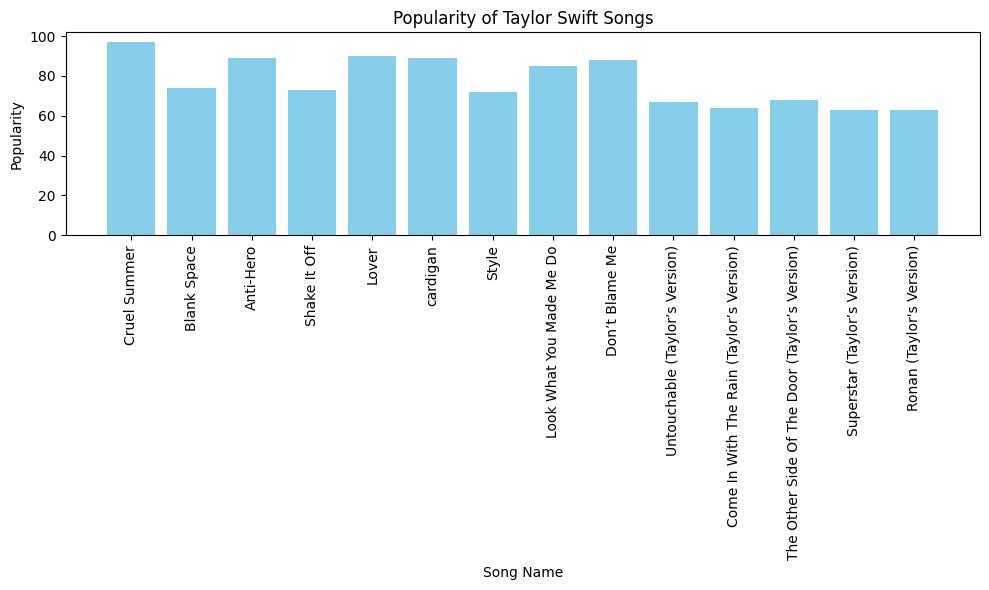

In [60]:
# Plot the bar chart
# Visualization of Song Popularity
plt.figure(figsize=(10, 6))
plt.bar(song_names, popularity, color='skyblue')
plt.xlabel('Song Name')
plt.ylabel('Popularity')
plt.title('Popularity of Taylor Swift Songs')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

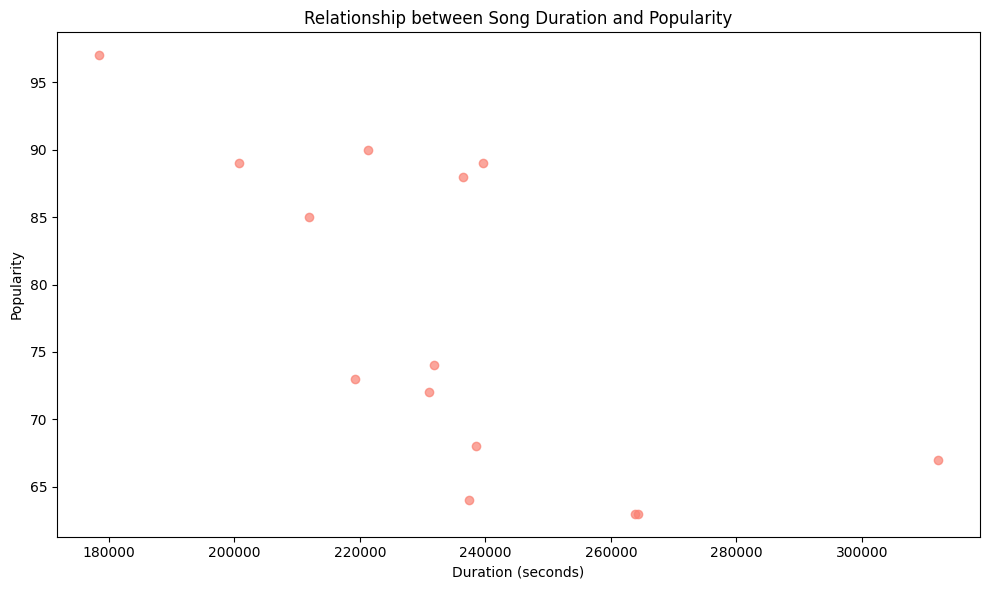

In [61]:
# Relationship between Song Duration and Popularity

# Extract duration and popularity columns
duration = df['Duration']
popularity = df['Popularity']

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(duration, popularity, color='salmon', alpha=0.7)
plt.xlabel('Duration (seconds)')
plt.ylabel('Popularity')
plt.title('Relationship between Song Duration and Popularity')
plt.tight_layout()
plt.show()

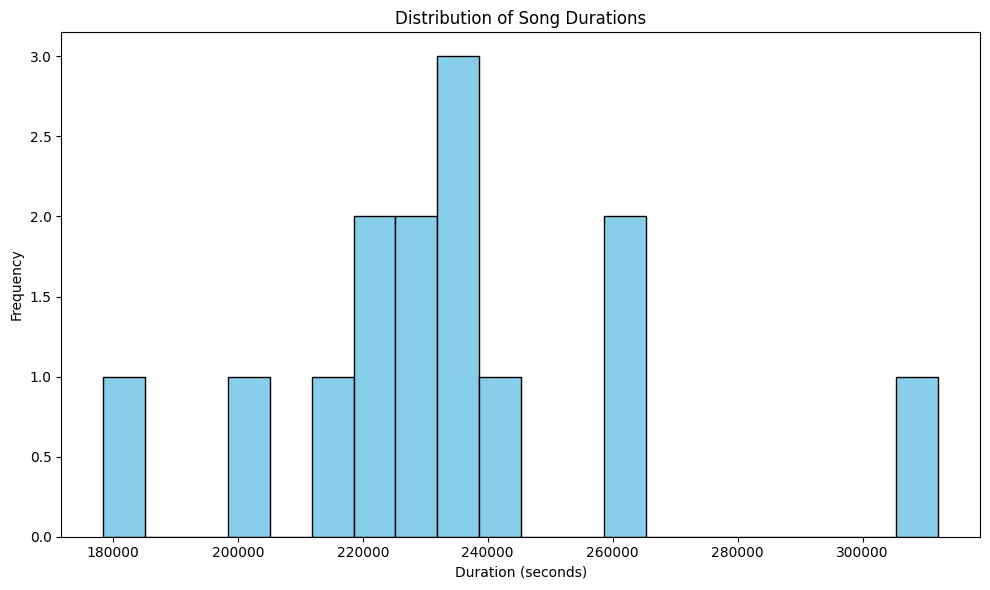

In [62]:
# Distribution of Song Durations

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(duration, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Song Durations')
plt.tight_layout()
plt.show()

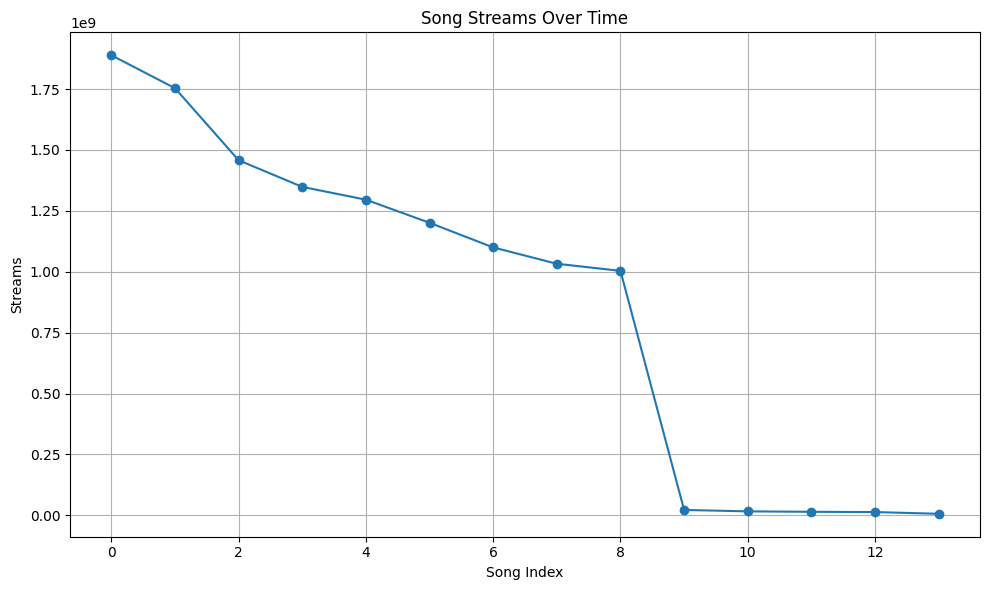

In [63]:
# Extract streams column
streams = df['Streams']
# Song Streams Over Time

# Plot the line graph
plt.figure(figsize=(10, 6))
plt.plot(streams, marker='o', linestyle='-')
plt.xlabel('Song Index')
plt.ylabel('Streams')
plt.title('Song Streams Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Extract release time 
release_time = df['Release Time']
# Extract streams data
streams = df['Streams']
# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(release_time, streams, marker='o', color='blue')
plt.xlabel('Release Time')
plt.ylabel('Streams')
plt.title('Streams Across Release Time')
plt.grid(True)
plt.tight_layout()
plt.show()
